In [218]:
import numpy as np
import pandas as pd

In [219]:
data = pd.read_csv("../datasets/cbecs2018_final_public.csv")

In [220]:
data.shape

(6436, 1249)

In [221]:
data.head()

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
0,1,3,5,2,3,210000,8,1,4,2,...,0,0,0,0,9,9,1,1,0,0
1,2,4,9,2,4,28000,5,1,6,1,...,0,0,0,0,0,0,9,9,9,9
2,3,3,5,8,4,2100,2,1,4,2,...,0,0,0,0,9,9,9,9,9,9
3,4,3,7,5,5,240000,8,2,6,1,...,0,0,0,0,1,1,9,9,9,9
4,5,1,2,5,3,295000,8,3,6,2,...,0,0,0,0,0,0,9,9,9,9


In [222]:
data.columns

Index(['PUBID', 'REGION', 'CENDIV', 'PBA', 'PUBCLIM', 'SQFT', 'SQFTC', 'WLCNS',
       'RFCNS', 'RFCOOL',
       ...
       'ZMFBTU', 'ZMFEXP', 'ZELCNS', 'ZELEXP', 'ZNGCNS', 'ZNGEXP', 'ZFKCNS',
       'ZFKEXP', 'ZDHBTU', 'ZDHEXP'],
      dtype='object', length=1249)

In [223]:
data.describe()

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
count,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6.436000e+03,6436.000000,6436.000000,6436.000000,6436.000000,...,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000
mean,3218.500000,2.629739,5.105811,12.564947,3.646830,1.691617e+05,5.611871,2.379273,4.355811,1.501554,...,0.429459,0.449658,0.407085,0.441112,2.871193,2.909571,6.785270,6.804848,8.273928,8.275637
std,1858.057498,1.006943,2.439221,11.937664,1.701329,2.851251e+05,2.304431,1.741901,2.081375,0.500036,...,1.092531,1.093648,1.090856,1.093221,3.978072,3.954940,3.681433,3.647798,2.358672,2.353031
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.001000e+03,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1609.750000,2.000000,3.000000,5.000000,2.000000,1.125000e+04,4.000000,1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,9.000000,9.000000
50%,3218.500000,3.000000,5.000000,13.000000,3.000000,6.900000e+04,6.000000,1.000000,5.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,9.000000,9.000000,9.000000
75%,4827.250000,3.000000,7.000000,16.000000,5.000000,2.100000e+05,8.000000,3.000000,6.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
max,6436.000000,4.000000,9.000000,91.000000,7.000000,2.100000e+06,10.000000,8.000000,8.000000,2.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


In [224]:
columns = ["DATACNTR", "TRNGRM", "STDNRM", "LGOFFDEV", "SMOFFDEV", "SERVER", "LAPTOP", "RFGSTO", "ELCOOL","GOVOWN", "PVC", \
           "PCTERMN", "LAPTPN", "TABLETN","SERVERN", "LGOFFDEVN", "SMOFFDEVN", "WBOARDSN", "COOLP", "DCNTRSFC", "ELEXP"]

In [225]:
df = data[columns]

In [226]:
df.head()

,DATACNTR,TRNGRM,STDNRM,LGOFFDEV,SMOFFDEV,SERVER,LAPTOP,RFGSTO,ELCOOL,GOVOWN,...,PCTERMN,LAPTPN,TABLETN,SERVERN,LGOFFDEVN,SMOFFDEVN,WBOARDSN,COOLP,DCNTRSFC,ELEXP
0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1,1,...,250.0,50.0,NaN,100.0,70.0,NaN,4.0,100.0,4.0,775800.0
1,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1,2,...,20.0,5.0,100.0,1.0,2.0,10.0,NaN,100.0,NaN,77933.0
2,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1,2,...,2.0,5.0,2.0,1.0,NaN,3.0,NaN,100.0,NaN,3472.0
3,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1,2,...,15.0,10.0,NaN,1.0,NaN,9.0,NaN,45.0,NaN,41197.0
4,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2,2,...,10.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,33688.0


In [227]:
df.describe()

,DATACNTR,TRNGRM,STDNRM,LGOFFDEV,SMOFFDEV,SERVER,LAPTOP,RFGSTO,ELCOOL,GOVOWN,...,PCTERMN,LAPTPN,TABLETN,SERVERN,LGOFFDEVN,SMOFFDEVN,WBOARDSN,COOLP,DCNTRSFC,ELEXP
count,5793.000000,5793.000000,5793.000000,6314.000000,6314.000000,6314.000000,6314.000000,5416.000000,6436.000000,6436.000000,...,5540.000000,4758.000000,3475.000000,3633.000000,3814.000000,5073.000000,1301.000000,5980.000000,897.000000,6.357000e+03
mean,1.845158,1.776627,1.831348,1.395946,1.196547,1.424612,1.246436,1.957164,1.114201,1.745960,...,173.868773,145.064523,101.355108,84.003303,72.832197,194.022078,118.190623,81.194314,2.147157,2.535272e+05
std,0.361785,0.416542,0.374476,0.489092,0.397419,0.494323,0.430970,0.202506,0.318080,0.435354,...,443.911787,308.190016,235.954625,826.355795,739.630732,1250.707378,953.921298,29.075135,1.277630,5.776407e+05
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.200000e+01
25%,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,6.000000,5.000000,5.000000,2.000000,2.000000,4.000000,4.000000,75.000000,1.000000,1.180600e+04
50%,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,...,30.000000,23.000000,20.000000,4.000000,5.000000,10.000000,12.000000,100.000000,2.000000,6.674000e+04
75%,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,...,150.000000,100.000000,99.500000,10.000000,15.000000,30.000000,40.000000,100.000000,3.000000,2.555860e+05
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3615.000000,1480.000000,1410.000000,9995.000000,9995.000000,9995.000000,9995.000000,100.000000,5.000000,1.487568e+07


In [228]:
missing_values = df.isnull().sum()
print(missing_values)


DATACNTR      643
TRNGRM        643
STDNRM        643
LGOFFDEV      122
SMOFFDEV      122
SERVER        122
LAPTOP        122
RFGSTO       1020
ELCOOL          0
GOVOWN          0
PVC          4137
PCTERMN       896
LAPTPN       1678
TABLETN      2961
SERVERN      2803
LGOFFDEVN    2622
SMOFFDEVN    1363
WBOARDSN     5135
COOLP         456
DCNTRSFC     5539
ELEXP          79
dtype: int64


In [229]:
df = df.dropna(subset=['ELEXP'])
df.shape

(6357, 21)

In [230]:
cat_cols = ["DATACNTR", "TRNGRM", "STDNRM", "LGOFFDEV", "SMOFFDEV", "SERVER", "LAPTOP", "RFGSTO", "ELCOOL","GOVOWN", "PVC", "DCNTRSFC" ]
cont_cols = ["PCTERMN", "LAPTPN", "TABLETN","SERVERN", "LGOFFDEVN", "SMOFFDEVN", "WBOARDSN", "COOLP", "ELEXP"]

In [231]:
unique_counts = df[cat_cols+cont_cols].nunique()
print(unique_counts)

DATACNTR        2
TRNGRM          2
STDNRM          2
LGOFFDEV        2
SMOFFDEV        2
SERVER          2
LAPTOP          2
RFGSTO          2
ELCOOL          2
GOVOWN          2
PVC             2
DCNTRSFC        5
PCTERMN       256
LAPTPN        176
TABLETN       113
SERVERN        76
LGOFFDEVN      72
SMOFFDEVN      98
WBOARDSN       78
COOLP          86
ELEXP        6232
dtype: int64


### Numerical Columns EDA

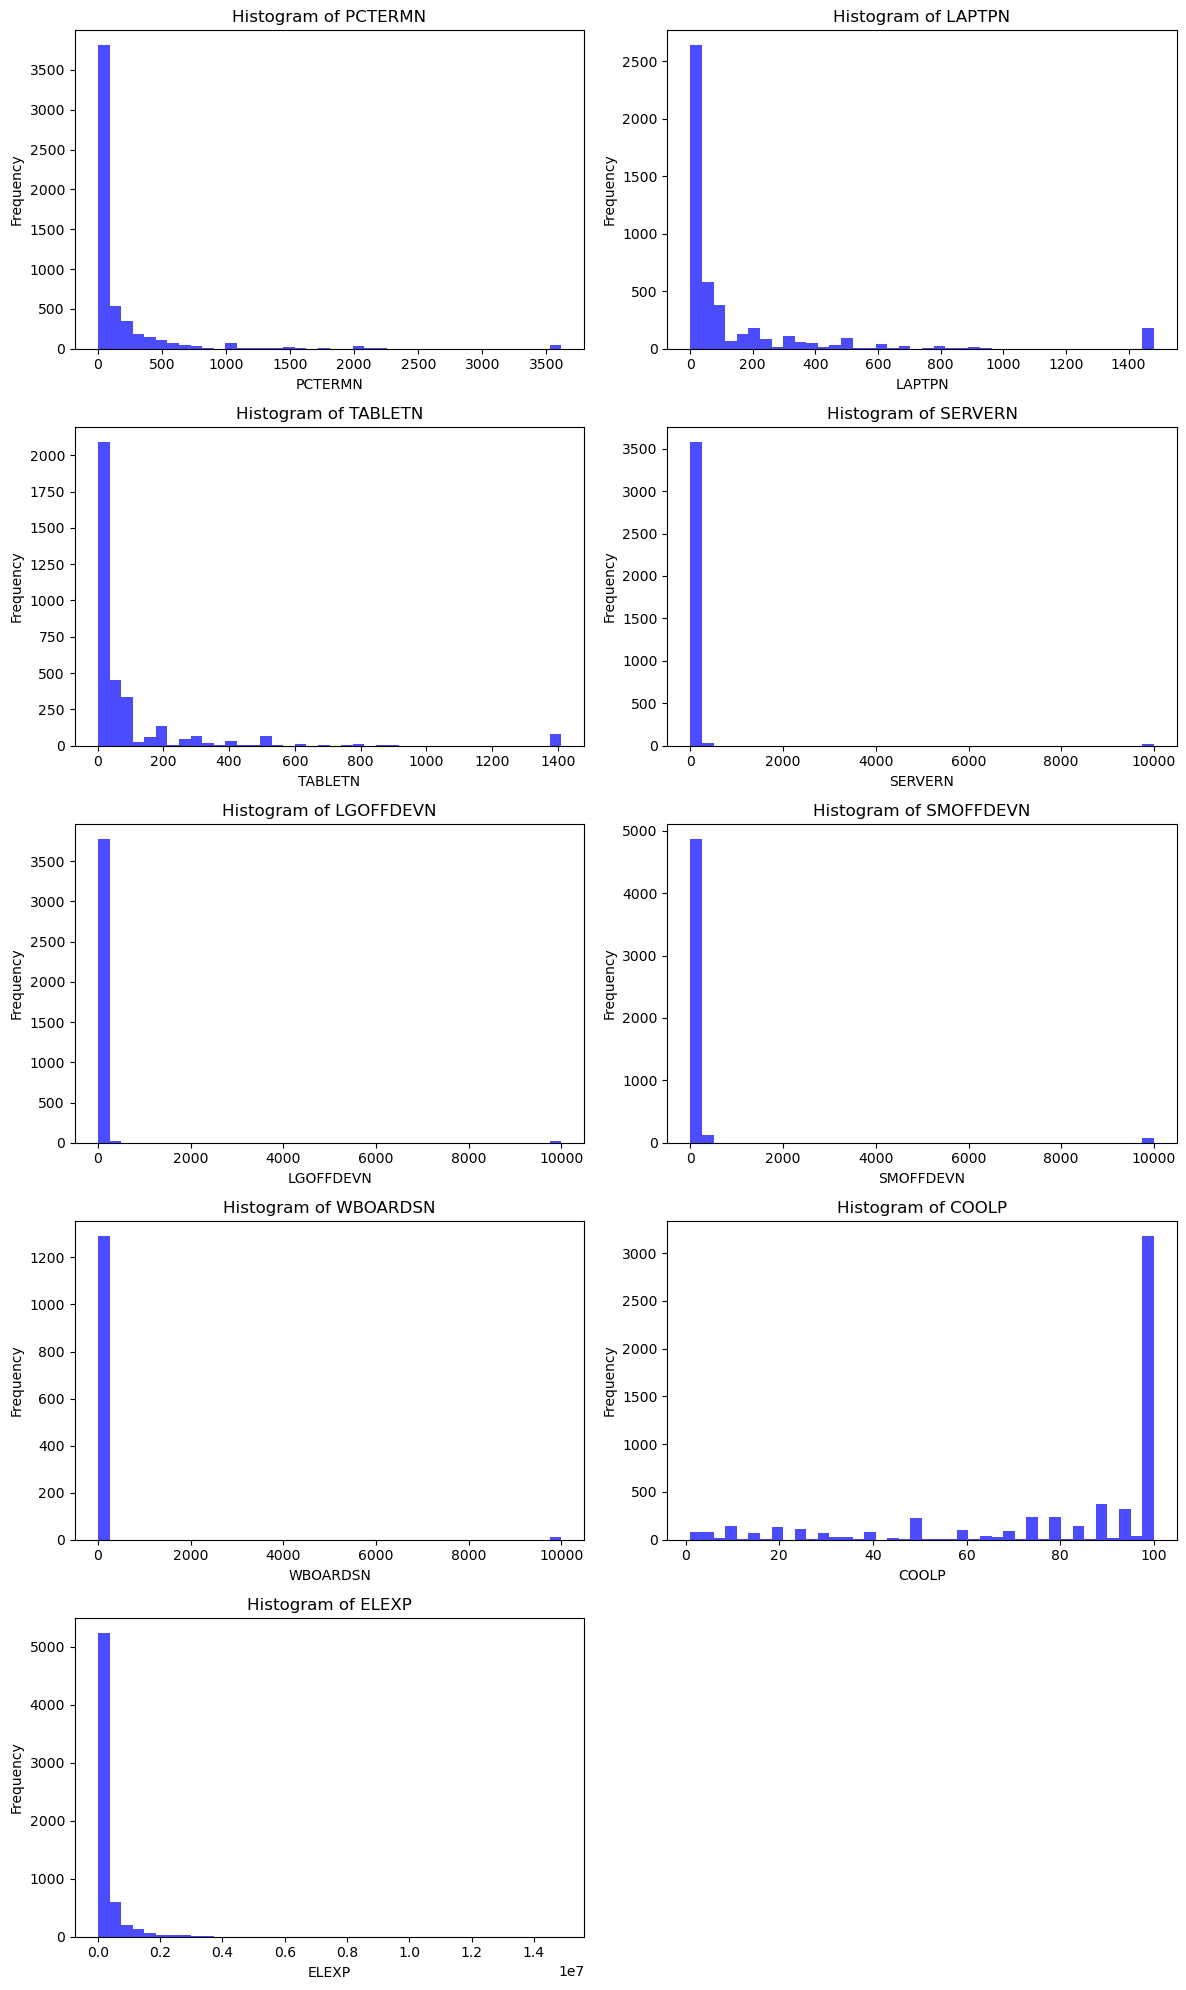

In [232]:
import matplotlib.pyplot as plt


num_cols = len(cont_cols)

# Create subplots
rows = (num_cols + 1) // 2  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot histograms
for i, col in enumerate(cont_cols):
    axes[i].hist(df[col].dropna(), bins=40, alpha=0.7, color='blue')  # Exclude NA values
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

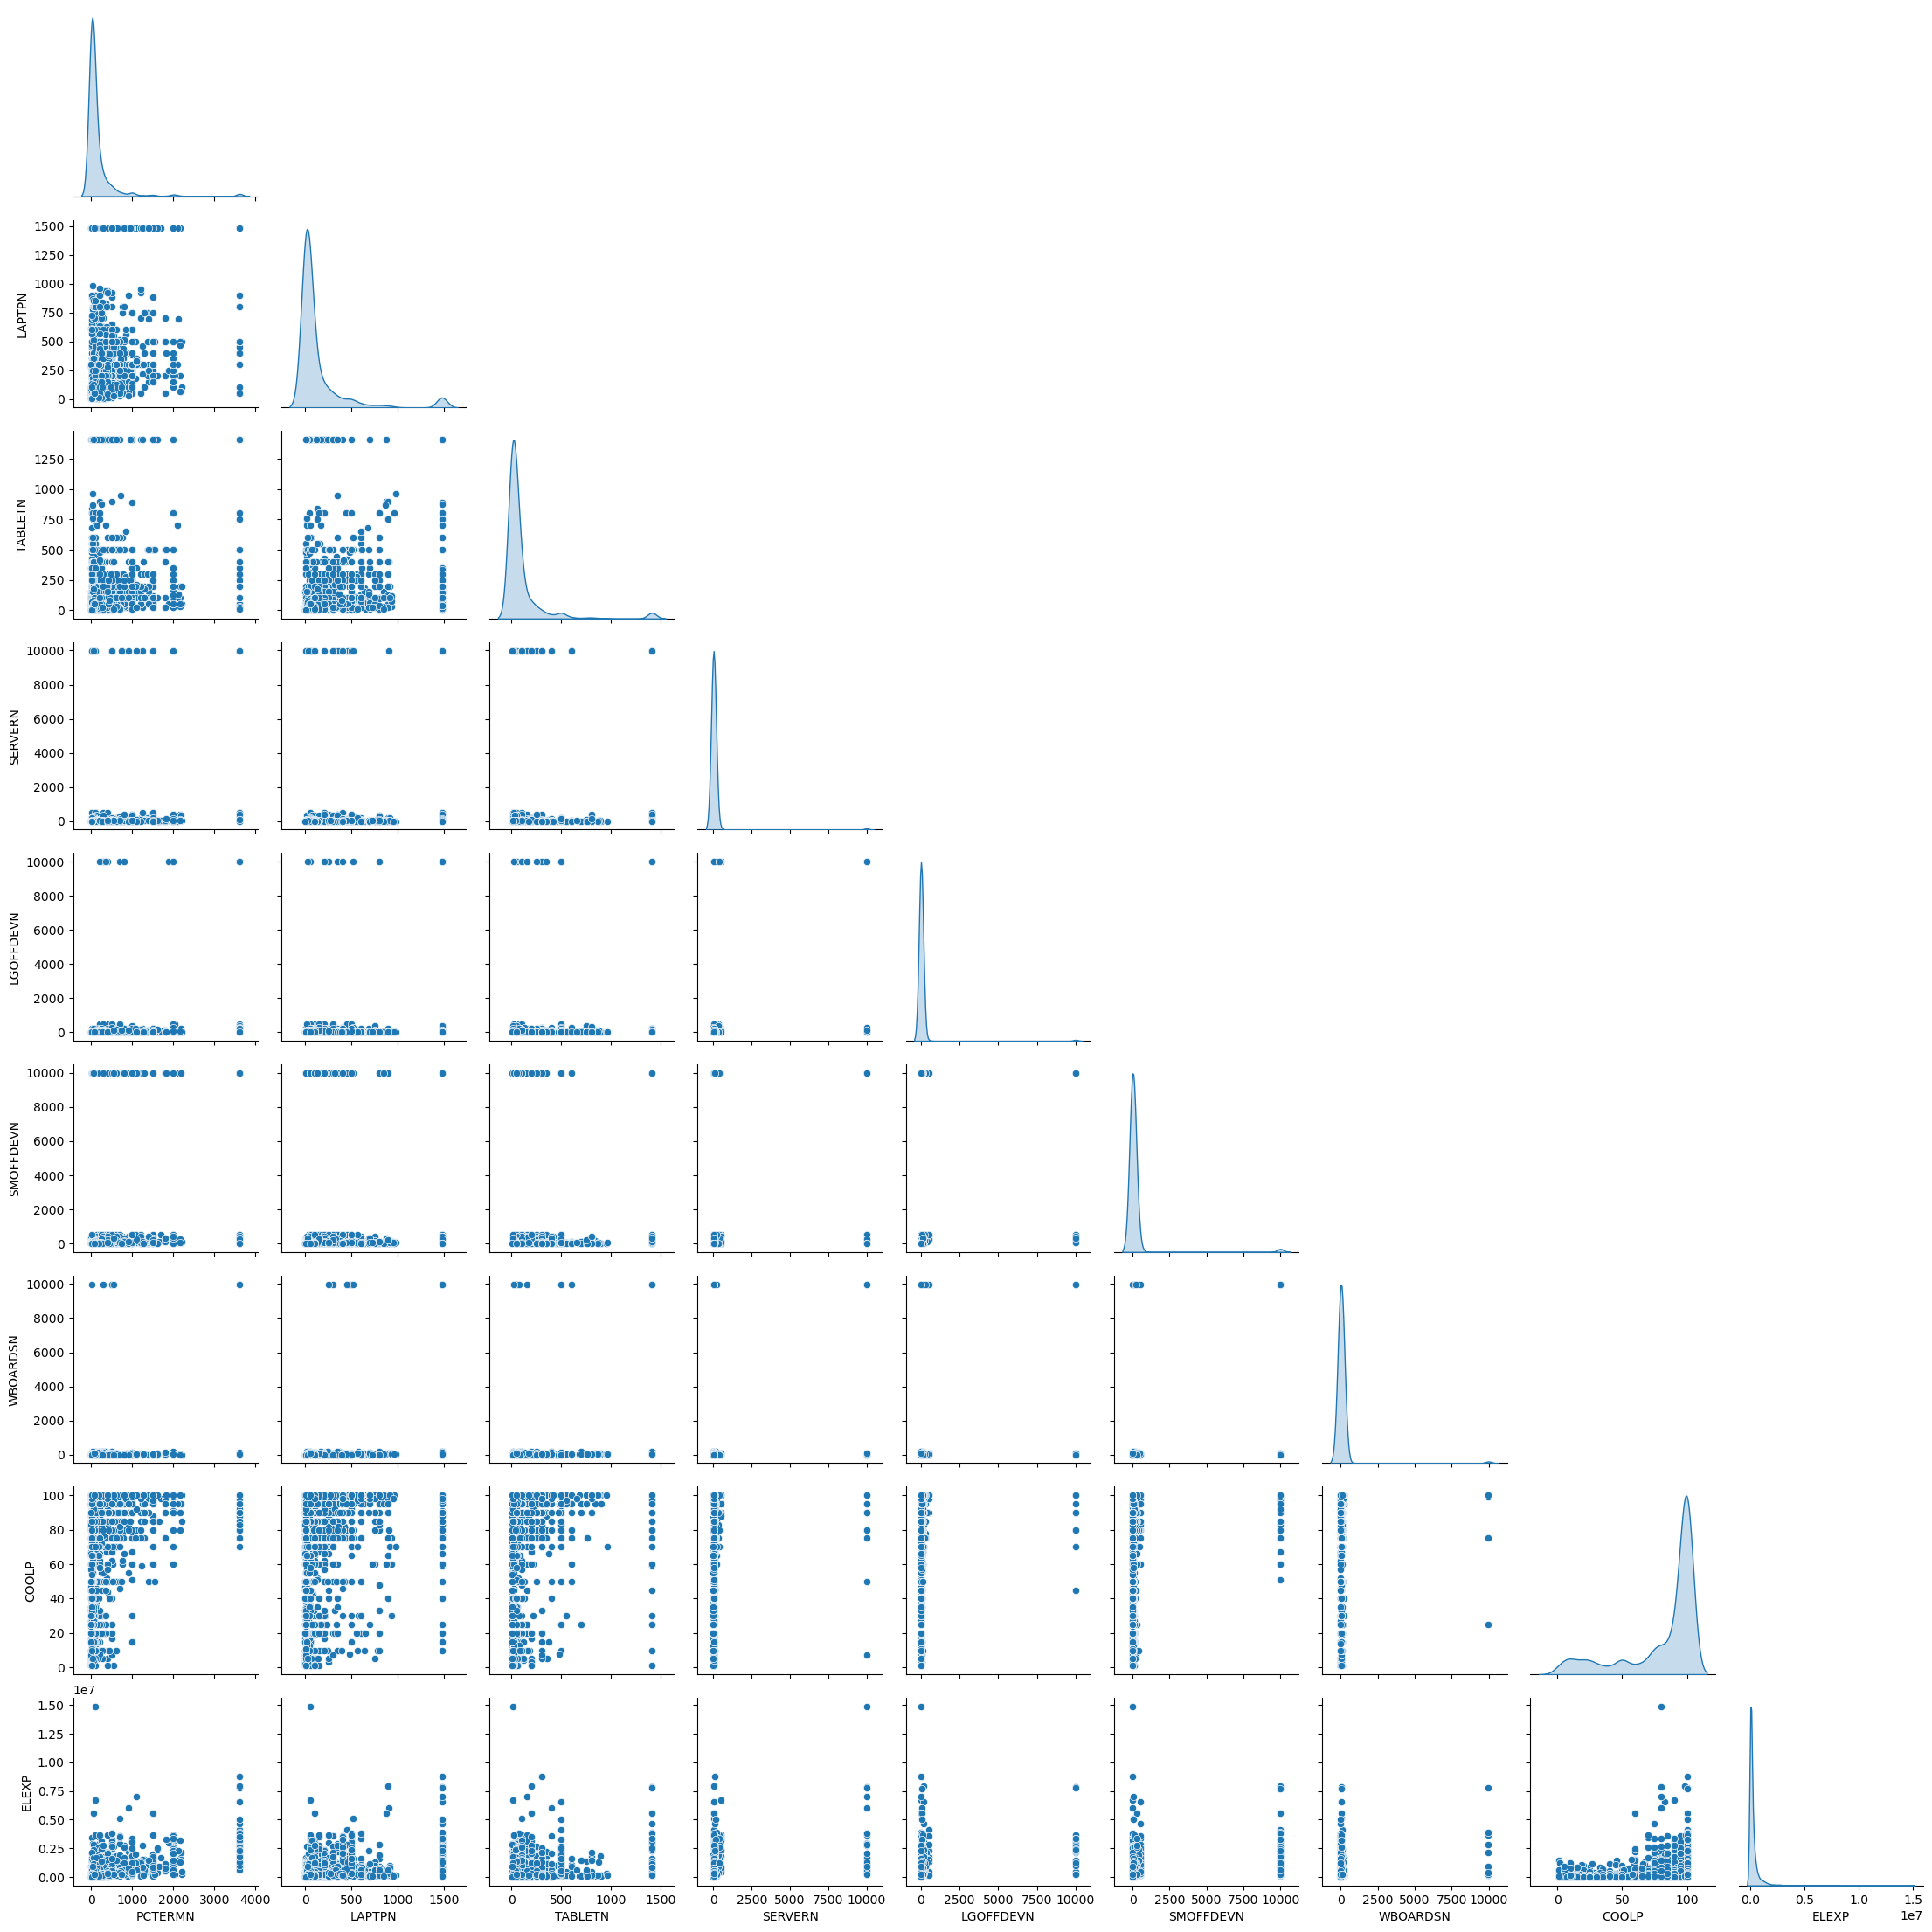

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pair plot
sns.pairplot(df[cont_cols], diag_kind='kde', corner=True)  # 'diag_kind' for diagonal plots; 'corner=True' for a lower triangle plot
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


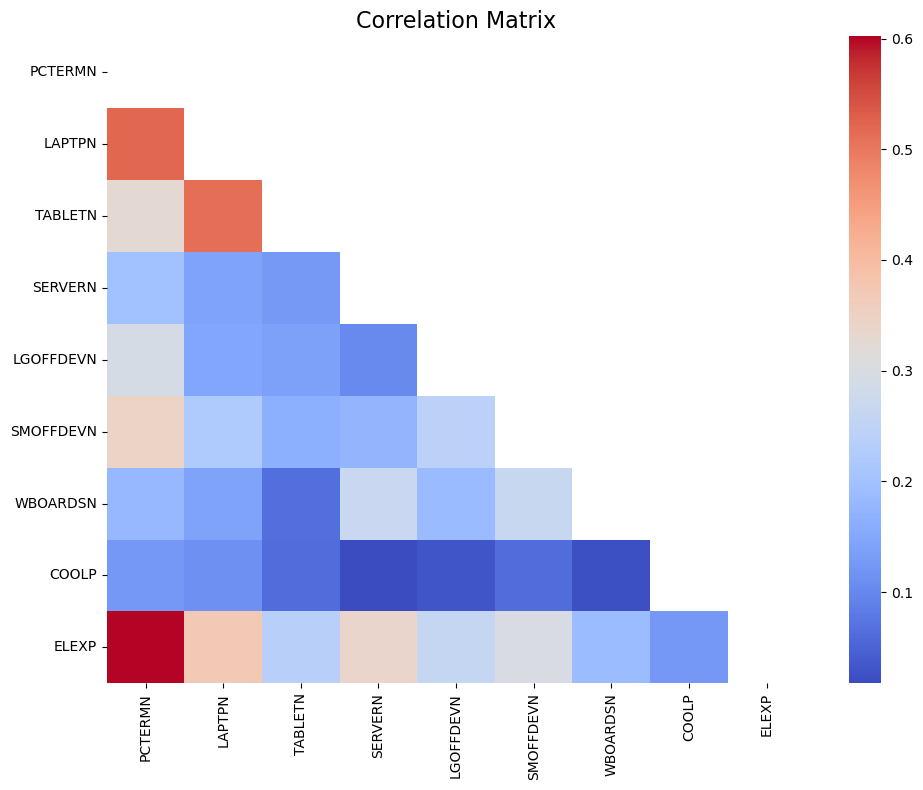

In [234]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Compute the correlation matrix for numerical columns
correlation_matrix = df[cont_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()


### Categorical EDA

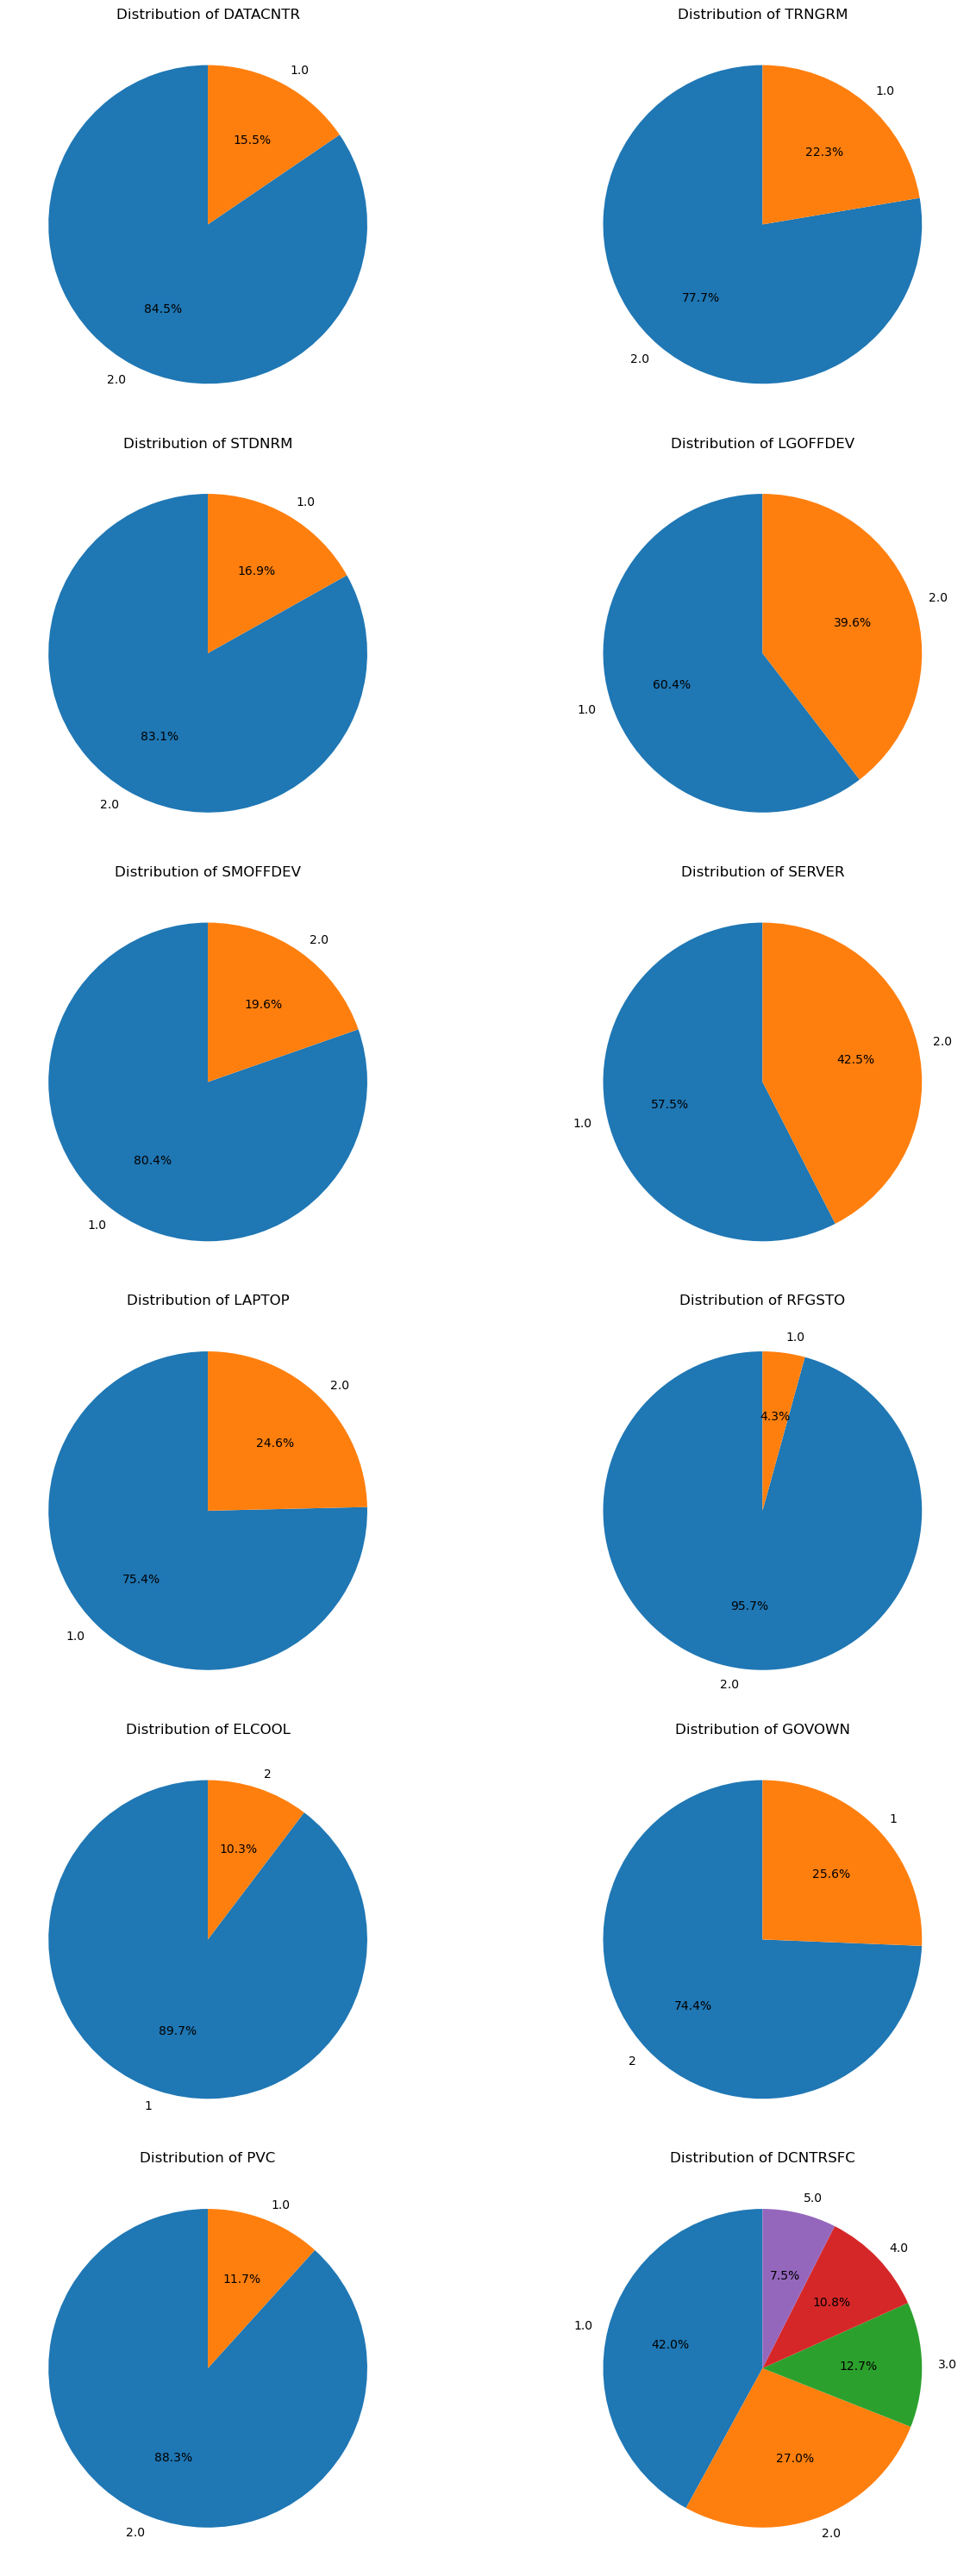

In [235]:
import matplotlib.pyplot as plt



# Determine the number of rows and columns for subplots
n_cols = 2  # Number of pie charts per row
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  # Calculate the number of rows

# Create a subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each categorical column and plot the pie chart
for i, col in enumerate(cat_cols):
    value_counts = df[col].value_counts(normalize=True) * 100  # Percentage of unique values
    labels = value_counts.index  # Categories as labels
    sizes = value_counts.values  # Percentages as sizes

    axes[i].pie(sizes, labels=labels, autopct="%.1f%%", startangle=90)
    axes[i].set_title(f"Distribution of {col}")

# Remove any extra subplots (if cat_cols < total grid slots)
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


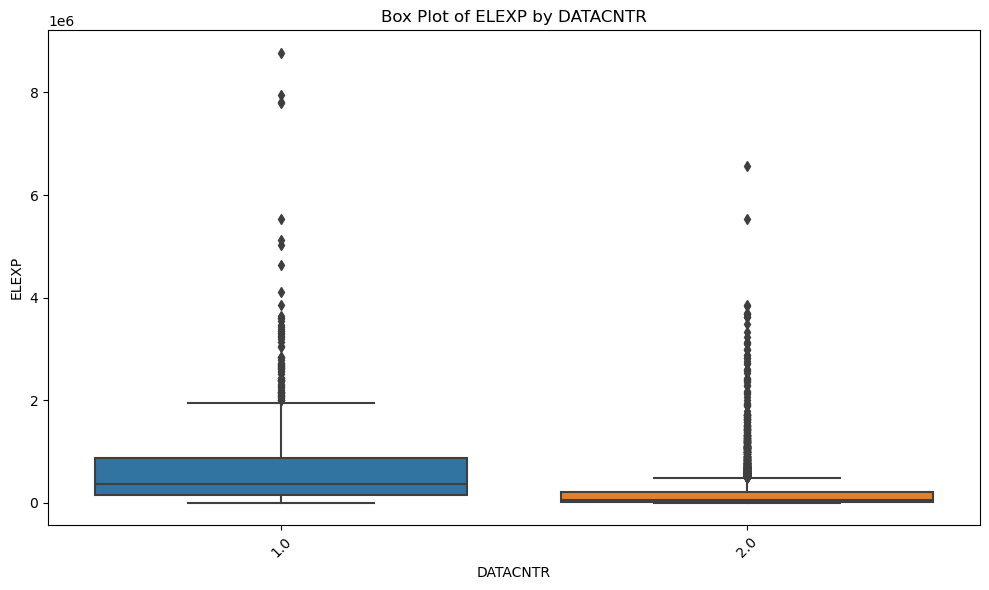

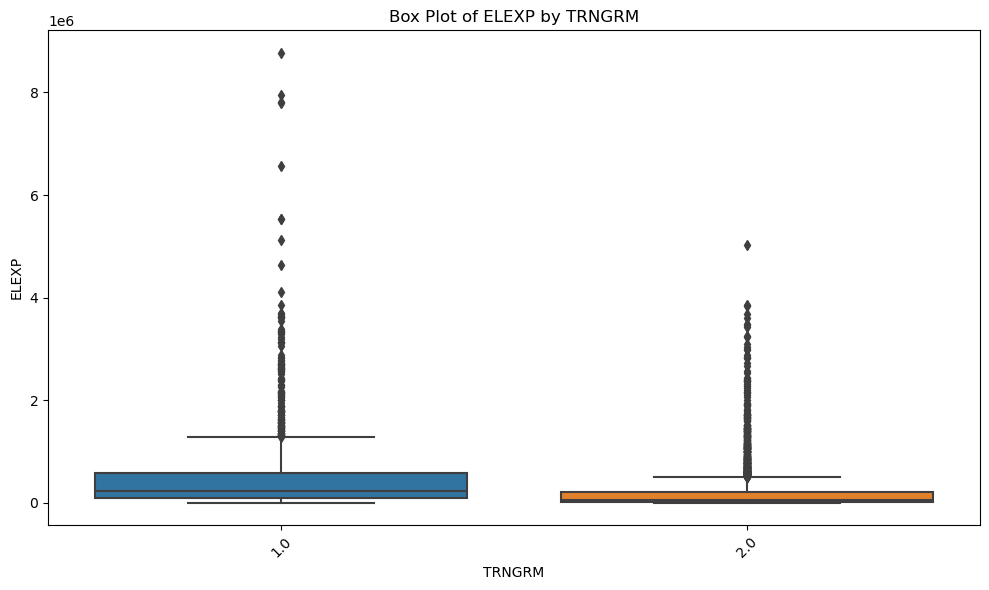

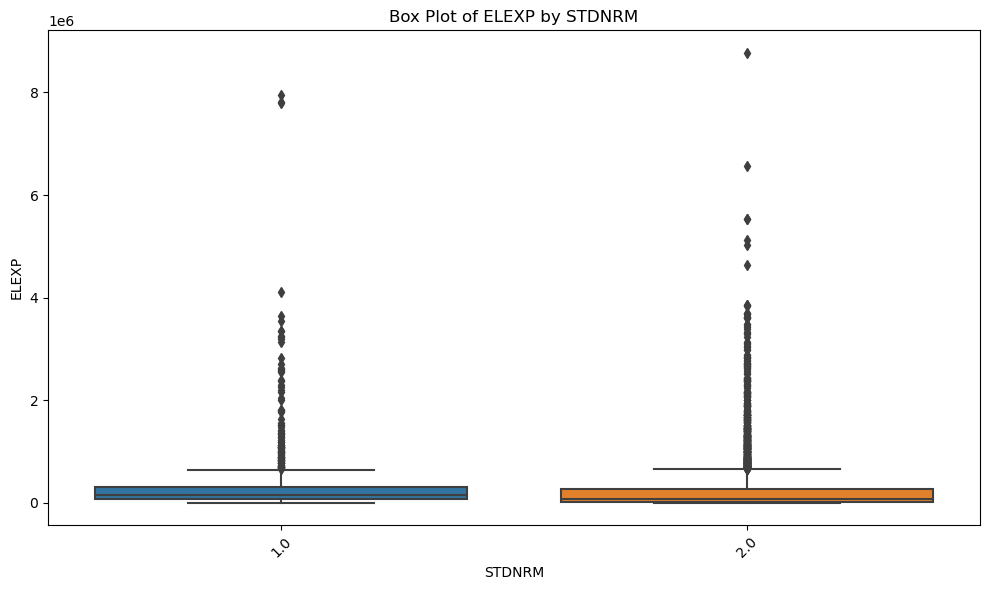

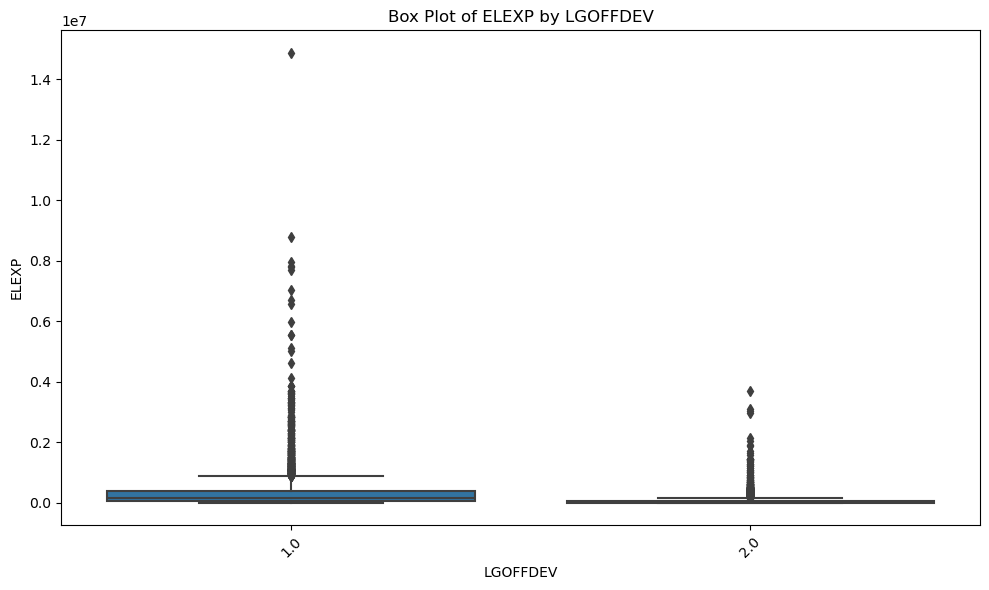

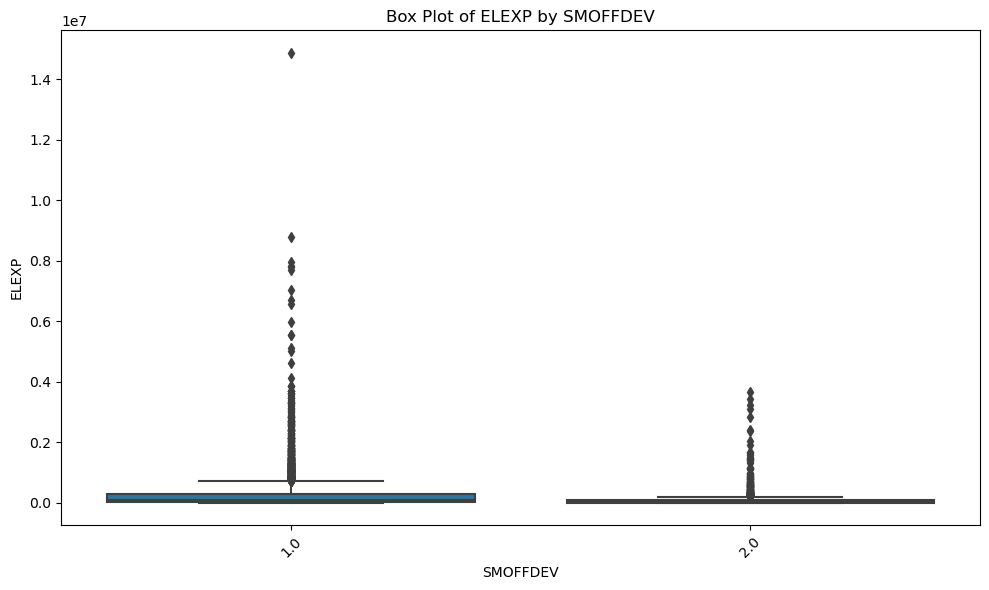

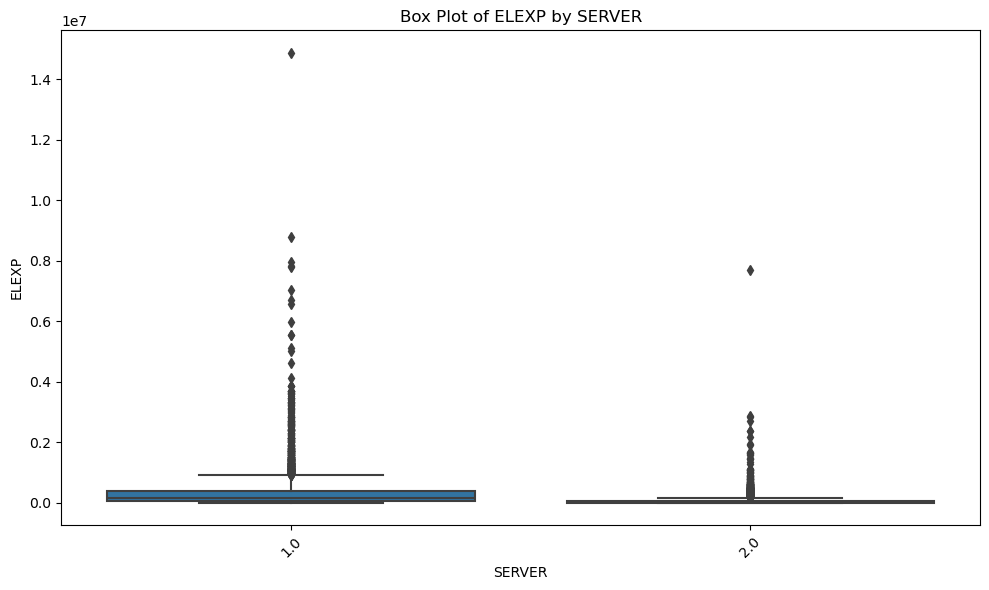

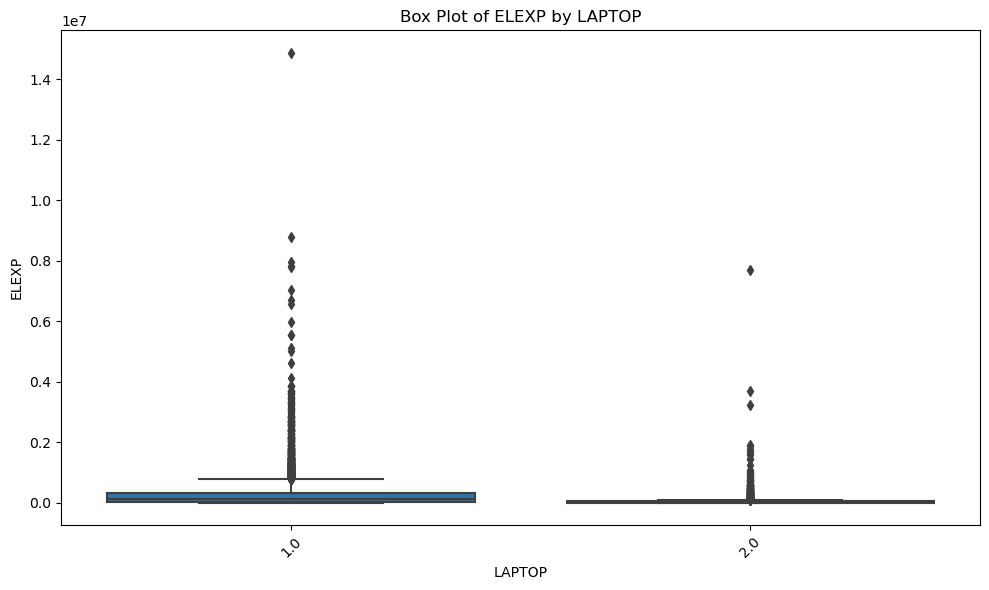

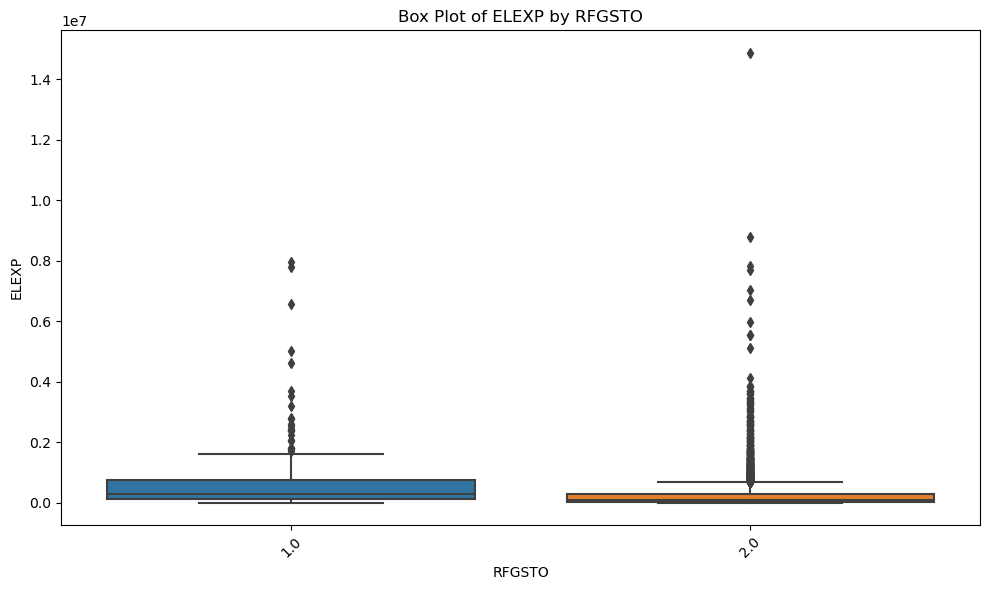

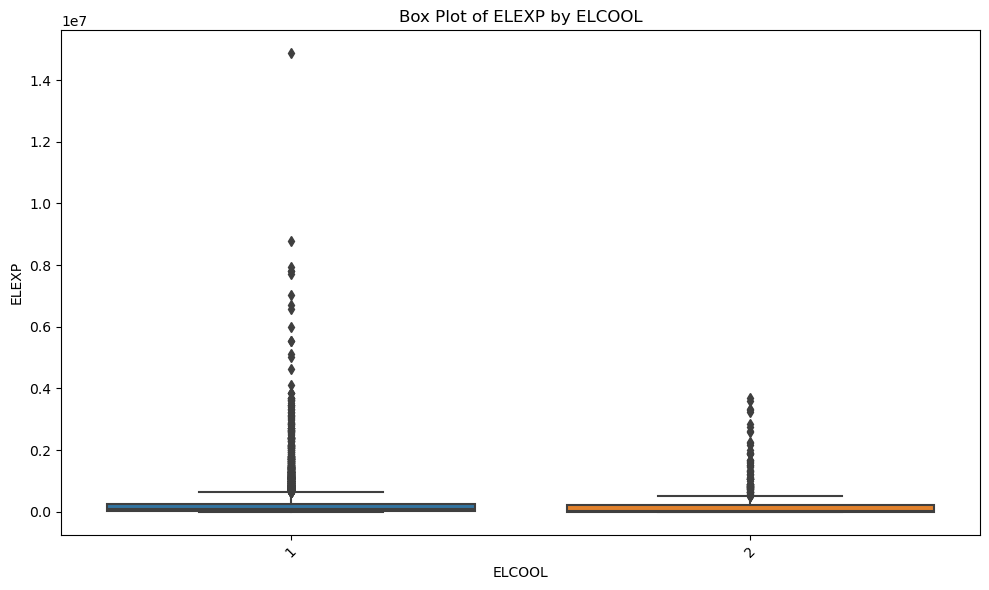

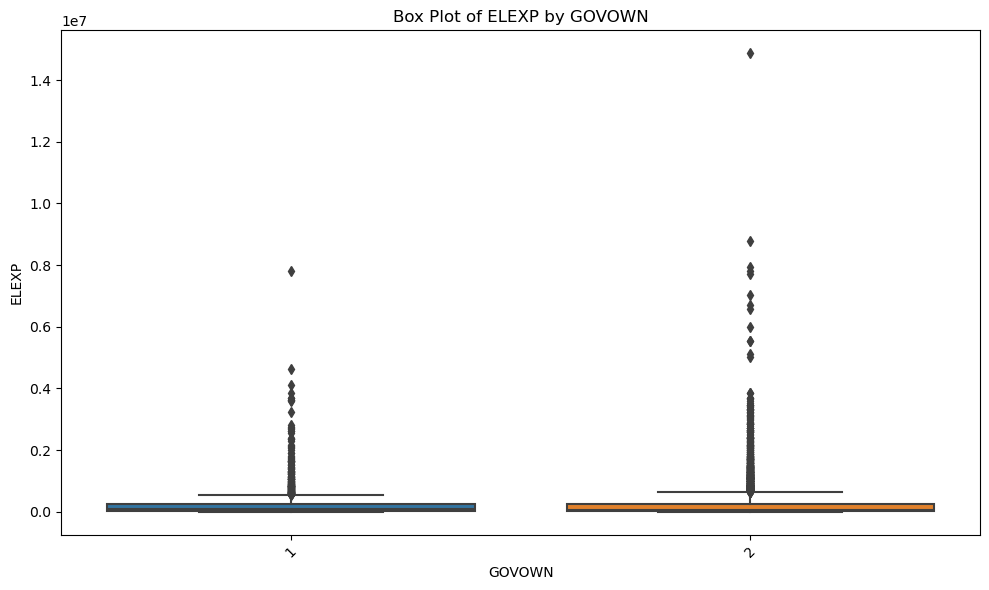

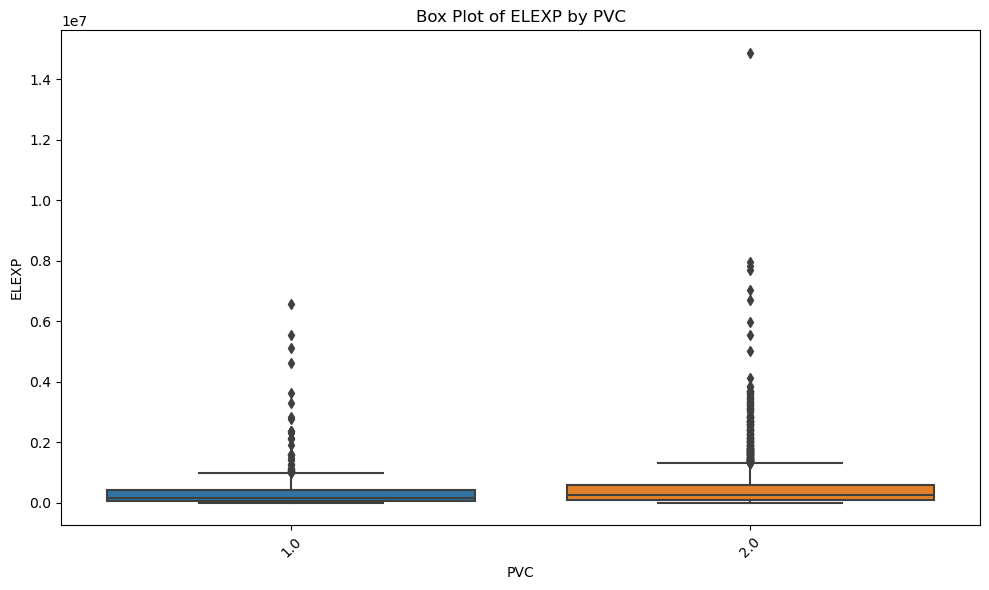

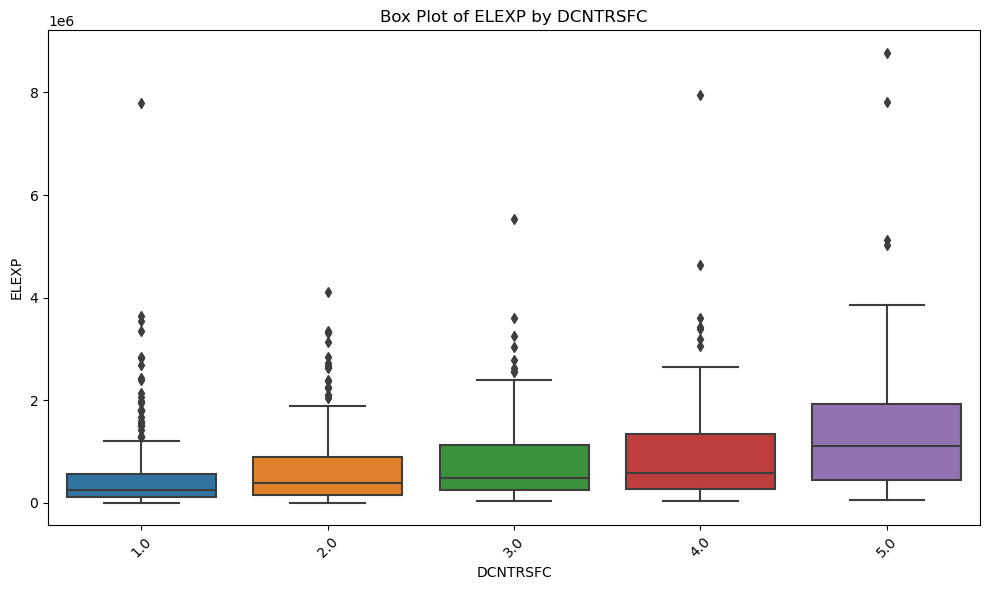

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume `cat_cols` contains the list of categorical columns
# Assume `num_col` is the numerical column for box plots
num_col = 'ELEXP'       # Replace with your actual numerical column

# Iterate through each categorical column
for cat_col in cat_cols:
    plt.figure(figsize=(10, 6))  # Set figure size
    sns.boxplot(x=cat_col, y=num_col, data=df)
    plt.title(f"Box Plot of {num_col} by {cat_col}")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()


In [237]:
from scipy.stats import f_oneway

target_col = "ELEXP"
for cat_col in cat_cols:
    df1 = df.dropna(subset=[cat_col, target_col])
    # Group numerical target by each category in the categorical column
    groups = [df1[target_col][df1[cat_col] == category] for category in df1[cat_col].unique()]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Display Results
    print(f"ANOVA results for {cat_col}:")
    print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 40)


ANOVA results for DATACNTR:
F-statistic: 776.3477, P-value: 0.0000
----------------------------------------
ANOVA results for TRNGRM:
F-statistic: 409.7428, P-value: 0.0000
----------------------------------------
ANOVA results for STDNRM:
F-statistic: 13.2202, P-value: 0.0003
----------------------------------------
ANOVA results for LGOFFDEV:
F-statistic: 355.9808, P-value: 0.0000
----------------------------------------
ANOVA results for SMOFFDEV:
F-statistic: 89.2297, P-value: 0.0000
----------------------------------------
ANOVA results for SERVER:
F-statistic: 395.2255, P-value: 0.0000
----------------------------------------
ANOVA results for LAPTOP:
F-statistic: 205.9224, P-value: 0.0000
----------------------------------------
ANOVA results for RFGSTO:
F-statistic: 104.1857, P-value: 0.0000
----------------------------------------
ANOVA results for ELCOOL:
F-statistic: 2.3134, P-value: 0.1283
----------------------------------------
ANOVA results for GOVOWN:
F-statistic: 1.445

In [238]:
from scipy.stats import kruskal


for cat_col in cat_cols:
    # Group the target variable by each category in the categorical column
    df1 = df.dropna(subset=[cat_col, target_col])
    groups = [df1[target_col][df1[cat_col] == category] for category in df1[cat_col].unique()]
    
    # Perform Kruskal-Wallis Test
    h_stat, p_value = kruskal(*groups)
    
    # Display Results
    print(f"Kruskal-Wallis Test results for {cat_col}:")
    print(f"H-statistic: {h_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 40)


Kruskal-Wallis Test results for DATACNTR:
H-statistic: 825.0591, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for TRNGRM:
H-statistic: 671.7663, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for STDNRM:
H-statistic: 162.8461, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for LGOFFDEV:
H-statistic: 1499.9431, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for SMOFFDEV:
H-statistic: 466.0940, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for SERVER:
H-statistic: 1531.6524, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for LAPTOP:
H-statistic: 1069.8098, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for RFGSTO:
H-statistic: 124.5608, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for

### Regression analysis

In [239]:
# cat_cols = ["DATACNTR", "TRNGRM", "STDNRM", "LGOFFDEV", "SMOFFDEV", "SERVER", "LAPTOP", "RFGSTO", "ELCOOL","GOVOWN"]
# cont_cols = ["PCTERMN", "LAPTPN", "TABLETN","SERVERN", "LGOFFDEVN", "SMOFFDEVN", "WBOARDSN", "COOLP", "ELEXP"]
# Replace NaN with median for all numerical columns
df = df[cont_cols+cat_cols]
df[cont_cols] = df[cont_cols].apply(lambda col: col.fillna(col.median()))

# Replace NaN with the mode (most frequent category) for categorical columns
df[cat_cols] = df[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))





In [240]:
import pandas as pd

# One-hot encode categorical columns
df_data_prep = pd.get_dummies(df, columns=cat_cols, drop_first=True)  # drop_first=True avoids dummy variable trap

# Convert all columns to integers
df_data_prep = df_data_prep.astype(int)

print("DataFrame after converting all columns to integers:")
print(df_data_prep.info())



from sklearn.preprocessing import MinMaxScaler

# Select the columns you want to normalize (typically numerical columns)
columns_to_normalize = cont_cols  # Assuming `cont_cols` contains numerical column names

# Initialize MinMaxScaler with the desired feature range
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the selected columns
df_data_prep[columns_to_normalize] = scaler.fit_transform(df_data_prep[columns_to_normalize])

print("One-hot encoded DataFrame & Normalized DataFrame:") 
print(df_data_prep.head())
print(df_data_prep.columns)

DataFrame after converting all columns to integers:
<class 'pandas.core.frame.DataFrame'>
Index: 6357 entries, 0 to 6435
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   PCTERMN       6357 non-null   int64
 1   LAPTPN        6357 non-null   int64
 2   TABLETN       6357 non-null   int64
 3   SERVERN       6357 non-null   int64
 4   LGOFFDEVN     6357 non-null   int64
 5   SMOFFDEVN     6357 non-null   int64
 6   WBOARDSN      6357 non-null   int64
 7   COOLP         6357 non-null   int64
 8   ELEXP         6357 non-null   int64
 9   DATACNTR_2.0  6357 non-null   int64
 10  TRNGRM_2.0    6357 non-null   int64
 11  STDNRM_2.0    6357 non-null   int64
 12  LGOFFDEV_2.0  6357 non-null   int64
 13  SMOFFDEV_2.0  6357 non-null   int64
 14  SERVER_2.0    6357 non-null   int64
 15  LAPTOP_2.0    6357 non-null   int64
 16  RFGSTO_2.0    6357 non-null   int64
 17  ELCOOL_2      6357 non-null   int64
 18  GOVOWN_2      6357 no

In [241]:
import statsmodels.api as sm
import numpy as np
import pandas as pd



# Prepare the features (X) and target (y)
X = df_data_prep.drop(columns=[target_col])
y = df[target_col]

# Add an intercept (constant) to the model
X_encoded = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X_encoded)
results = model.fit()

# Print the summary of the model (which includes p-values)
print(results.summary())

# Extract the p-values for each feature and interaction term
p_values = results.pvalues
print(p_values)


                            OLS Regression Results                            
Dep. Variable:                  ELEXP   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     231.3
Date:                Sat, 30 Nov 2024   Prob (F-statistic):               0.00
Time:                        06:21:36   Log-Likelihood:                -91418.
No. Observations:                6357   AIC:                         1.829e+05
Df Residuals:                    6333   BIC:                         1.830e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.032e+06   8.92e+04     33.995   

In [242]:
X.shape

(6357, 23)

Sahpe of X_train (5085, 23)
Shape of X_test (1272, 23)
Mean Squared Error: 0.0034
R² Score: 0.4635


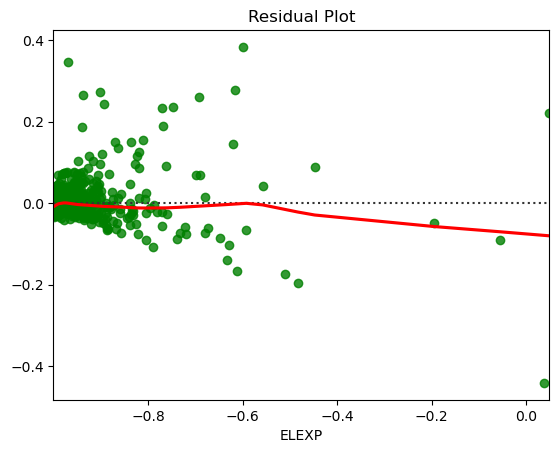

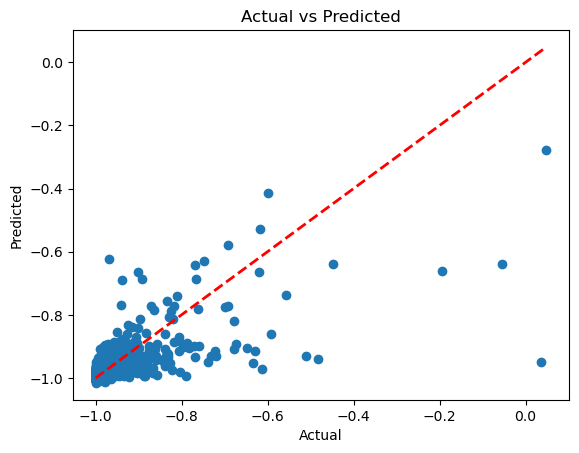

In [245]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


X = df_data_prep.drop(columns=[target_col])  # Features (independent variables)
y = df_data_prep[target_col]  # Target (dependent variable)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Sahpe of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

sns.residplot(x=y_test, y=y_pred, lowess=True, color="g", line_kws={'color': 'red'})
plt.title("Residual Plot")
plt.show()

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()


Shape of X_train: (5085, 23)
Shape of X_test: (1272, 23)
Tuning Ridge...
Best Ridge Parameters: {'alpha': 10}
Best Ridge R² (CV): 0.4209
Tuning Lasso...
Best Lasso Parameters: {'alpha': 0.01}
Best Lasso R² (CV): 0.0501
Tuning ElasticNet...
Best ElasticNet Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
Best ElasticNet R² (CV): 0.3935

Best Model: Ridge
Mean Squared Error (Test): 0.0034
R² Score (Test): 0.4615


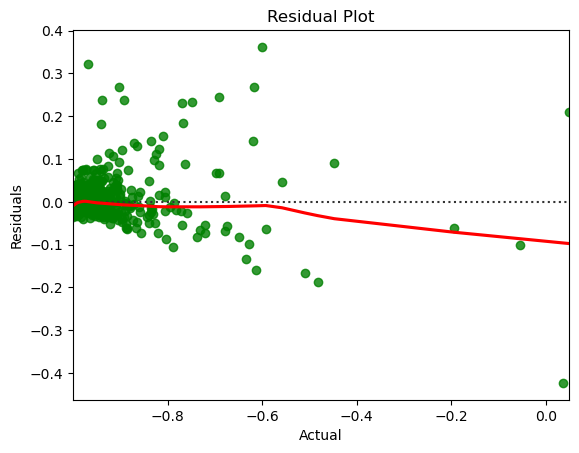

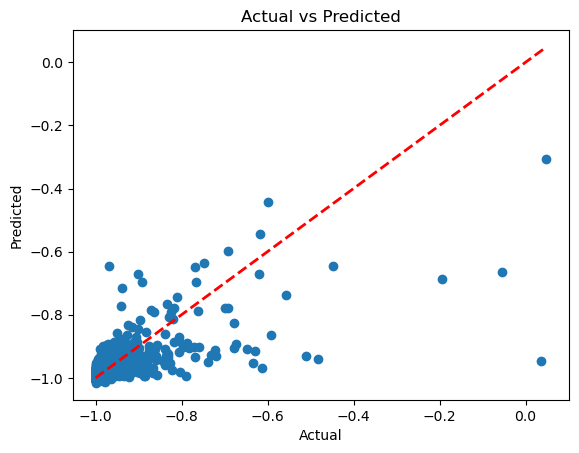

In [251]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define features and target
X = df_data_prep.drop(columns=[target_col])  # Features (independent variables)
y = df_data_prep[target_col]  # Target (dependent variable)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Define models and their hyperparameter grids
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet()
}

param_grids = {
    "Ridge": {"alpha": [0.01, 0.1, 1, 10, 100]},
    "Lasso": {"alpha": [0.01, 0.1, 1, 10, 100]},
    "ElasticNet": {
        "alpha": [0.01, 0.1, 1, 10, 100],
        "l1_ratio": [0.1, 0.5, 0.7, 1.0]
    }
}

best_models = {}
best_scores = {}

# Perform grid search for each model
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_
    print(f"Best {model_name} Parameters: {grid_search.best_params_}")
    print(f"Best {model_name} R² (CV): {grid_search.best_score_:.4f}")

# Evaluate the best model on the test set
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (Test): {mse:.4f}")
print(f"R² Score (Test): {r2:.4f}")

# Residual plot
sns.residplot(x=y_test, y=y_pred, lowess=True, color="g", line_kws={'color': 'red'})
plt.title("Residual Plot")
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.show()

# Actual vs Predicted plot
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()


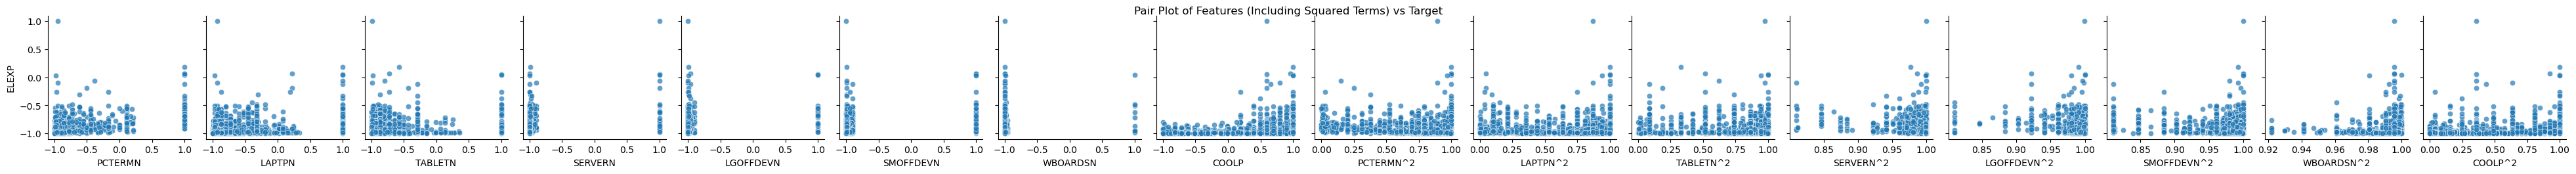

Shape of X_poly_train: (5085, 31)
Shape of X_poly_test: (1272, 31)
Linear Regression with Squared Terms Performance:
Mean Squared Error: 0.0034
R² Score: 0.4675


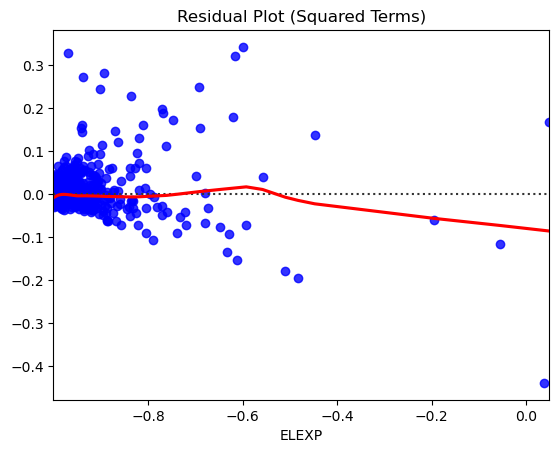

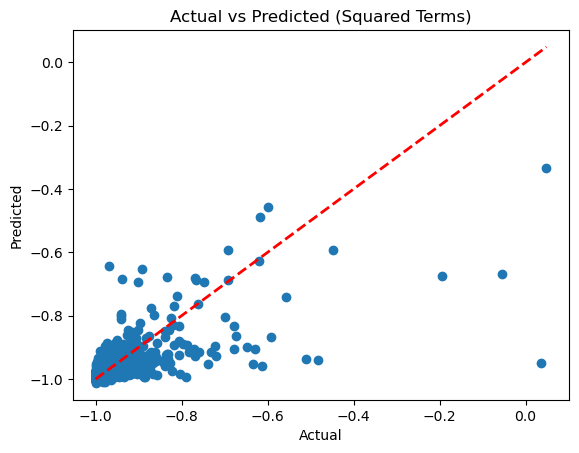

In [258]:
# Assume `cont_cols` is a list of continuous columns in your dataset
cont_cols_1 = cont_cols
cont_cols_1.remove("ELEXP")

# Create a new dataframe `df_poly` with squared terms for continuous columns
df_poly = df_data_prep.copy()
for col in cont_cols:
    if col != "ELEXP":
        df_poly[f"{col}^2"] = df_poly[col] ** 2

# Visualize relationships with a pair plot
sns.pairplot(df_poly, x_vars=cont_cols + [f"{col}^2" for col in cont_cols], y_vars=target_col, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.7})
plt.suptitle("Pair Plot of Features (Including Squared Terms) vs Target", y=1.02)
plt.show()

# Define features and target from `df_poly`
X_poly = df_poly.drop(columns=[target_col])
y_poly = df_poly[target_col]

# Split the data into training and testing sets
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)
print("Shape of X_poly_train:", X_poly_train.shape)
print("Shape of X_poly_test:", X_poly_test.shape)

# Train a Linear Regression model on the new dataset with squared terms
model_poly = LinearRegression()
model_poly.fit(X_poly_train, y_poly_train)

# Make predictions
y_poly_pred = model_poly.predict(X_poly_test)

# Evaluate the model
mse_poly = mean_squared_error(y_poly_test, y_poly_pred)
r2_poly = r2_score(y_poly_test, y_poly_pred)

print(f"Linear Regression with Squared Terms Performance:")
print(f"Mean Squared Error: {mse_poly:.4f}")
print(f"R² Score: {r2_poly:.4f}")

# Visualizations for the new model
sns.residplot(x=y_poly_test, y=y_poly_pred, lowess=True, color="b", line_kws={'color': 'red'})
plt.title("Residual Plot (Squared Terms)")
plt.show()

plt.scatter(y_poly_test, y_poly_pred)
plt.plot([min(y_poly_test), max(y_poly_test)], [min(y_poly_test), max(y_poly_test)], '--r', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Squared Terms)")
plt.show()


In [264]:
df_data_prep[cont_cols]

,PCTERMN,LAPTPN,TABLETN,SERVERN,LGOFFDEVN,SMOFFDEVN,WBOARDSN,COOLP
0,-0.862203,-0.933739,-0.973031,-0.980188,-0.986192,-0.998199,-0.999400,1.000000
1,-0.989485,-0.994591,-0.859475,-1.000000,-0.999800,-0.998199,-0.997799,1.000000
2,-0.999447,-0.994591,-0.998581,-1.000000,-0.999200,-0.999600,-0.997799,1.000000
3,-0.992252,-0.987830,-0.973031,-1.000000,-0.999200,-0.998399,-0.997799,-0.111111
4,-0.995019,-0.970250,-0.973031,-0.999400,-0.999200,-0.997799,-0.997799,1.000000
...,...,...,...,...,...,...,...,...
6430,-0.983951,-0.460446,-0.575586,-0.998999,-0.999200,-0.999200,-0.997799,0.959596
6431,-0.983951,1.000000,-0.575586,-0.999400,-0.998599,-0.999400,-0.997799,0.959596
6433,-0.779192,-0.629479,-0.973031,-0.996598,-0.999200,-0.998199,-0.997799,1.000000
6434,-0.995573,-0.998648,-0.998581,-0.999400,-0.999600,-0.999600,-0.997799,1.000000


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


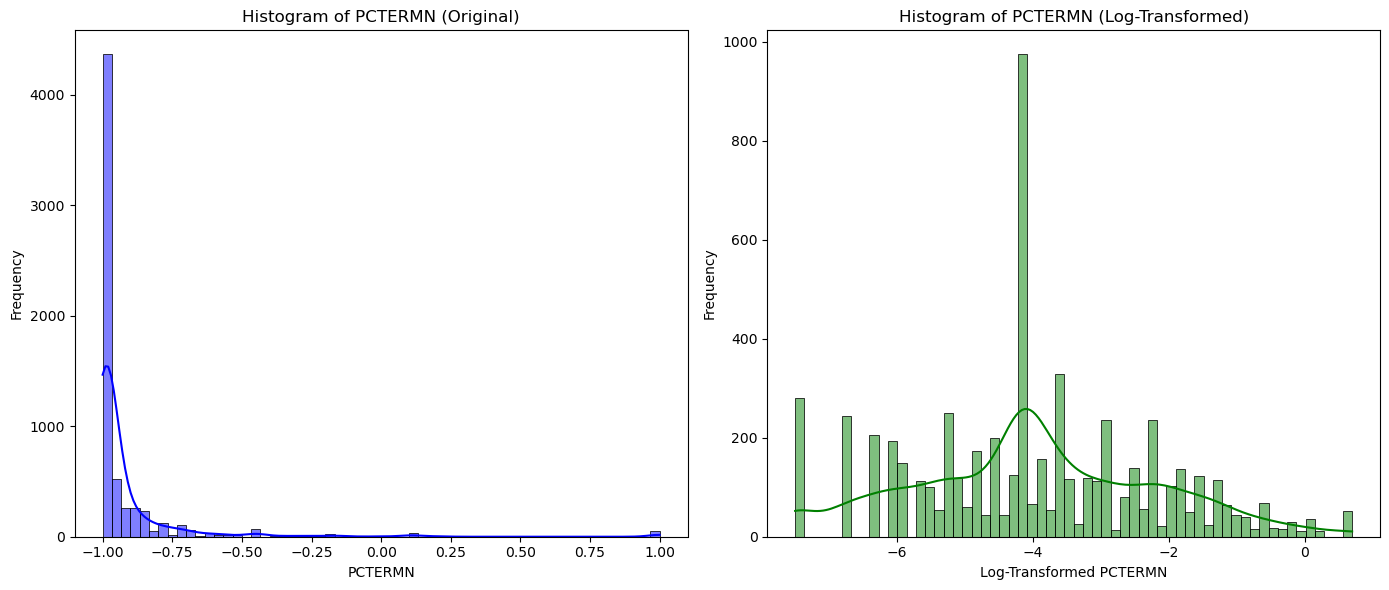

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


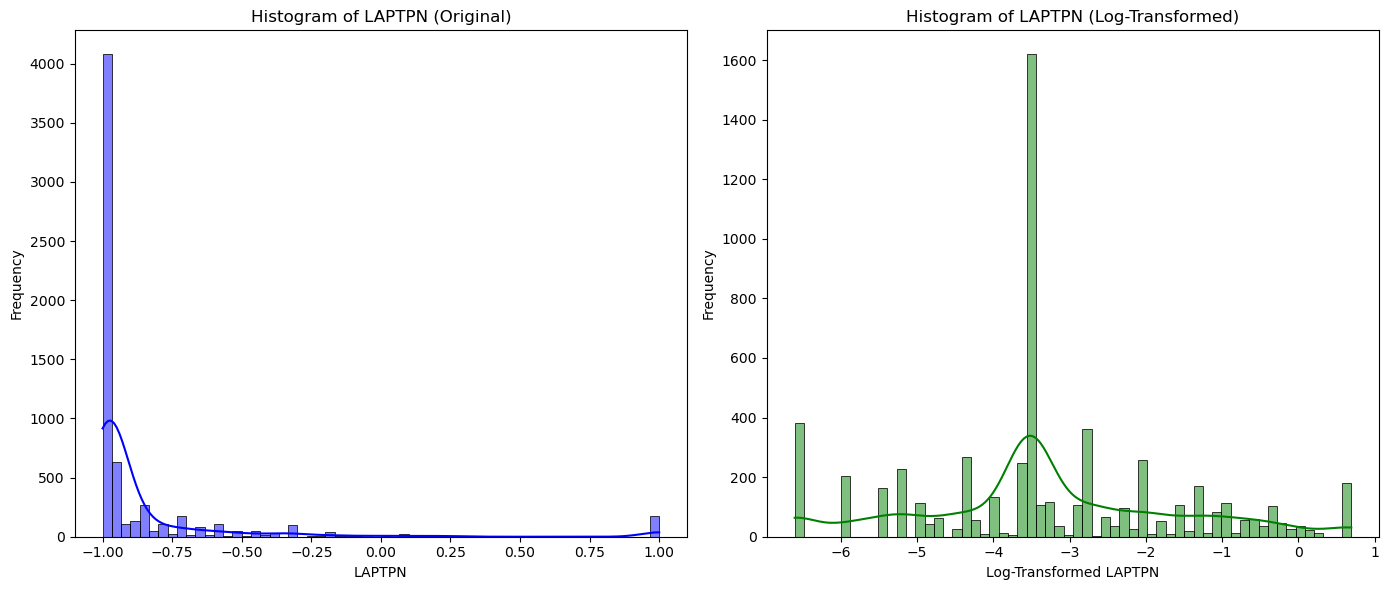

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


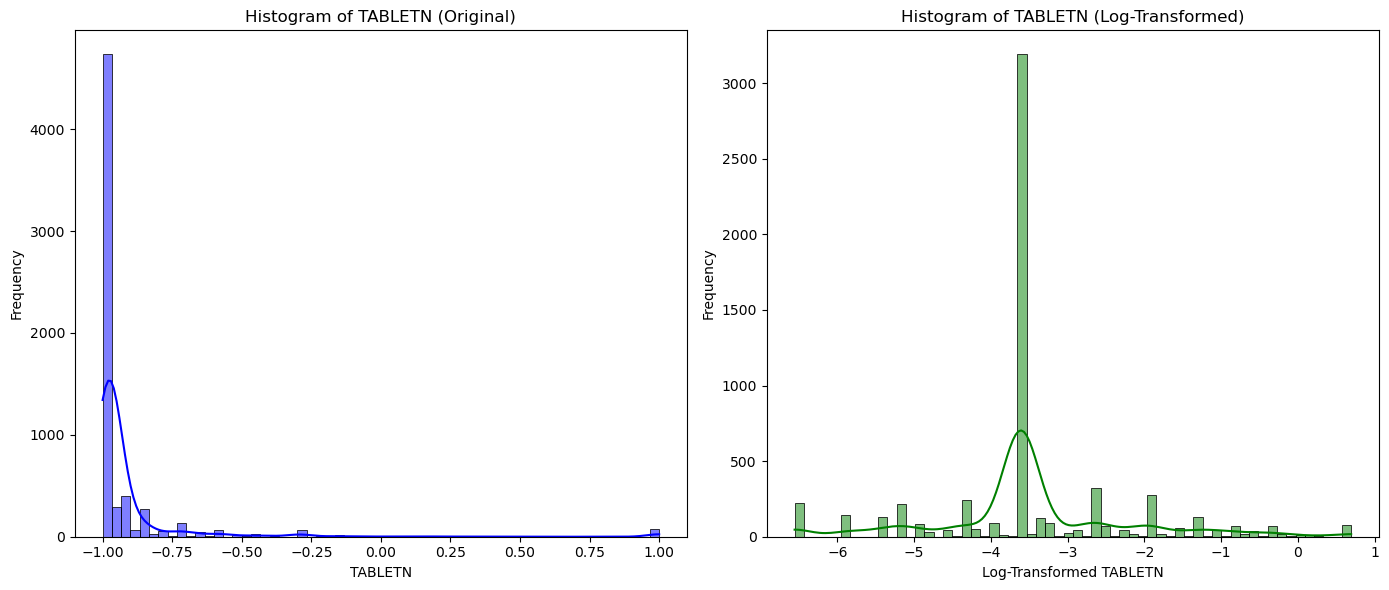

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


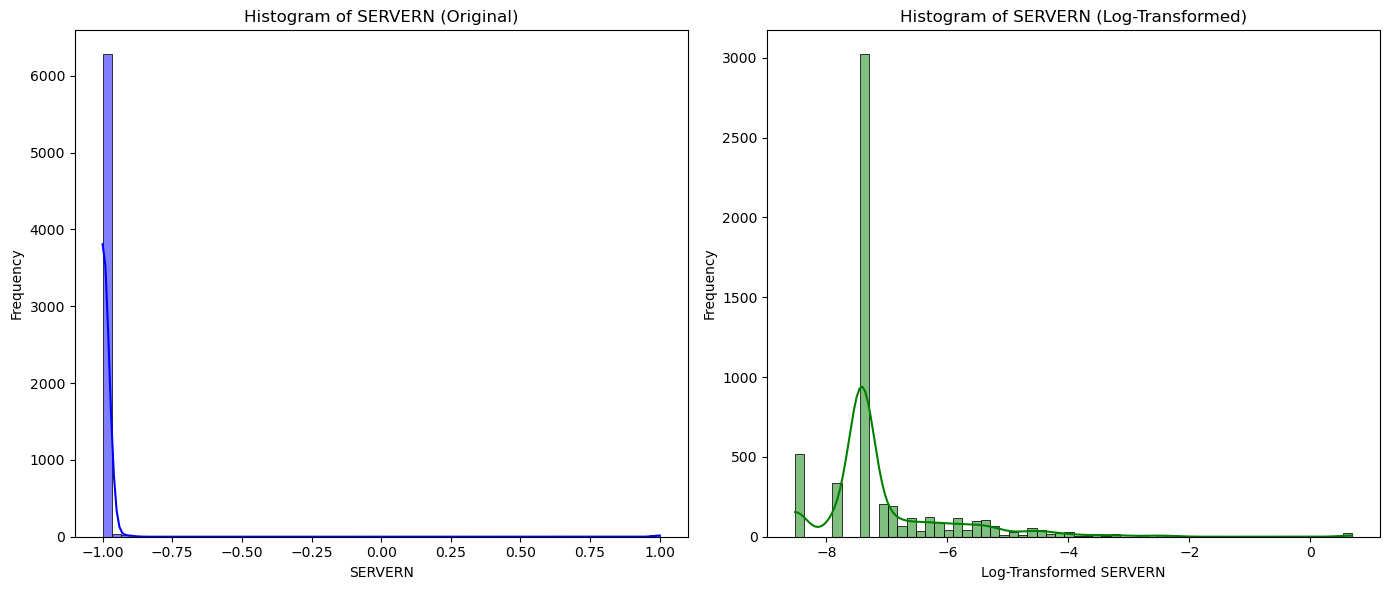

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


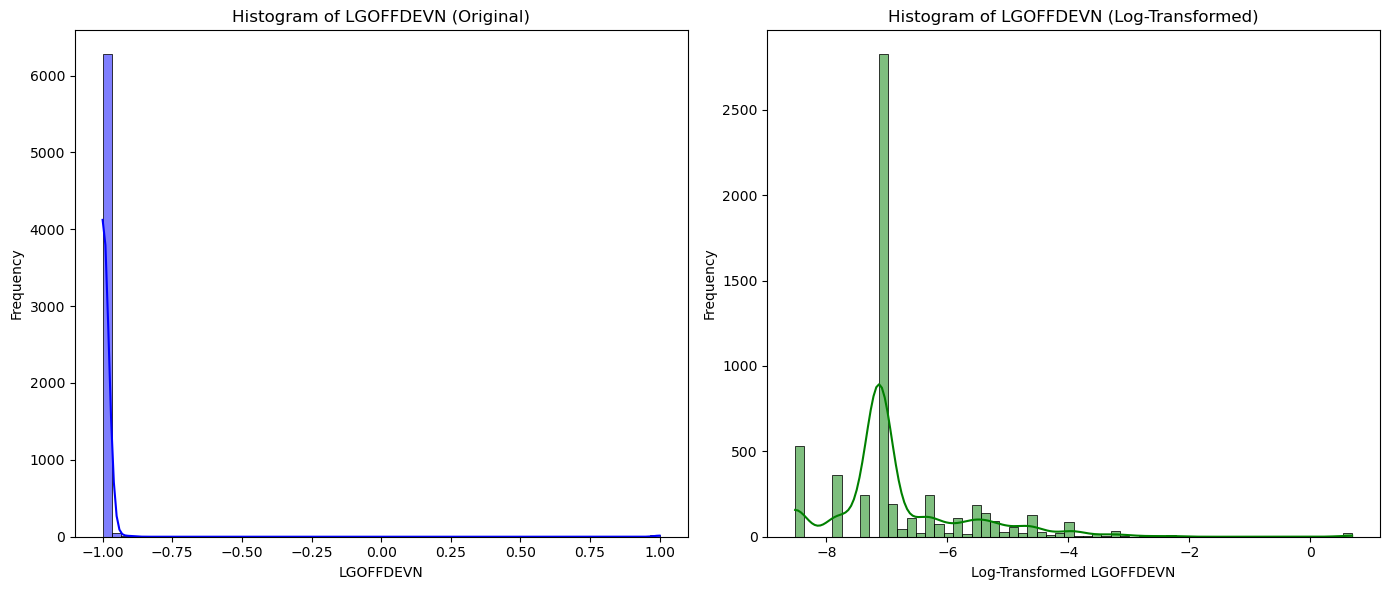

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


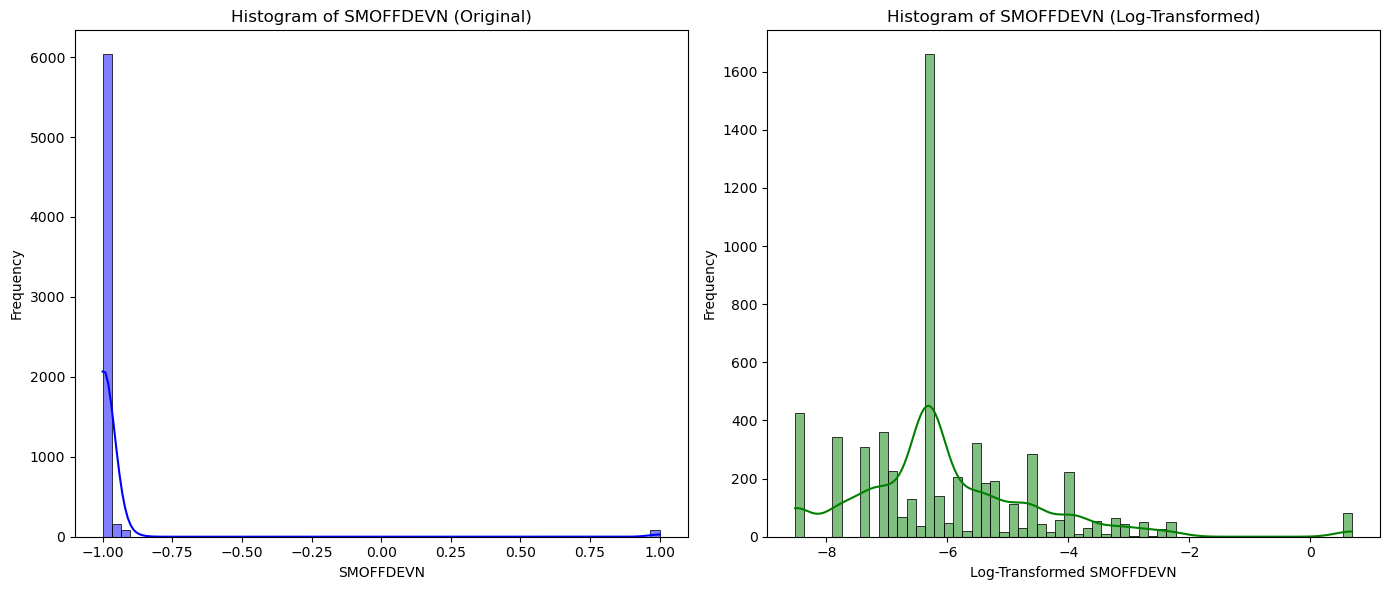

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


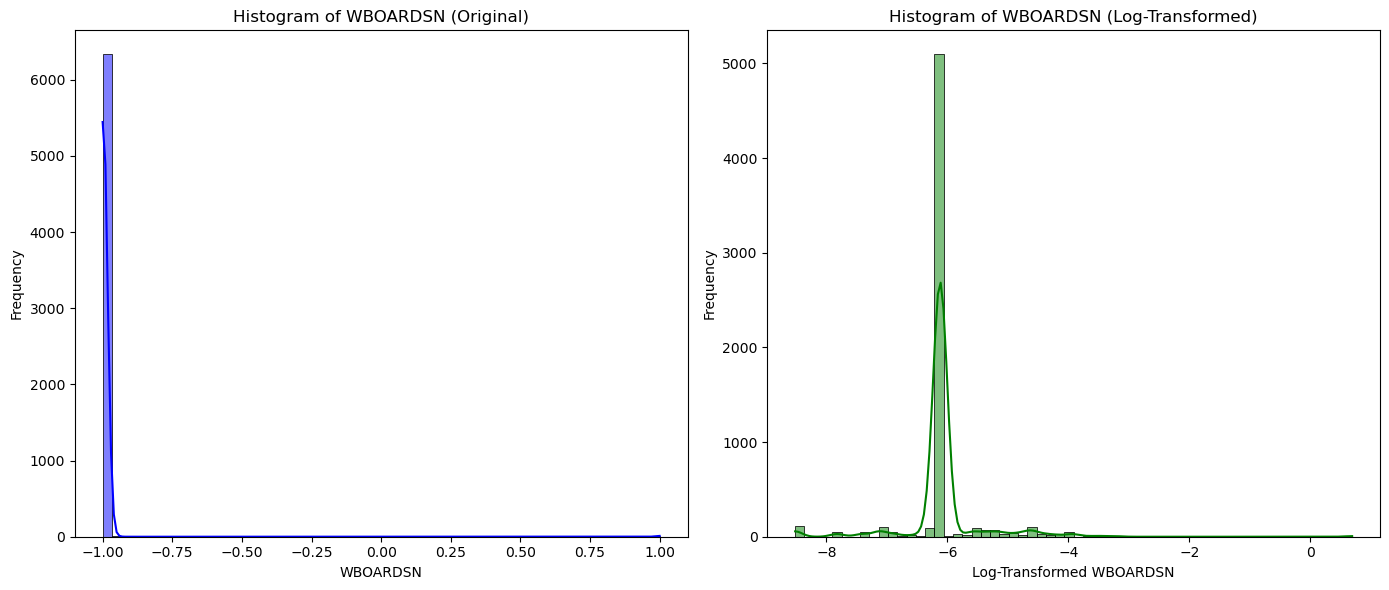

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


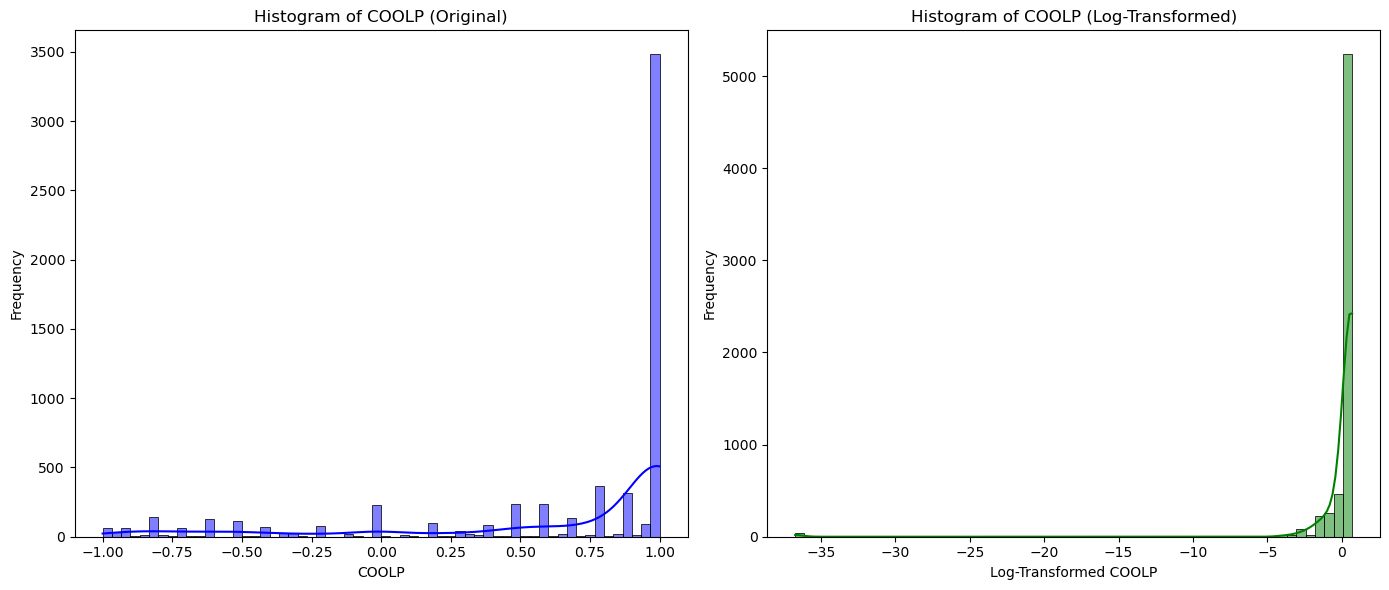

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure no negative values before log transformation
def safe_log_transform(series):
    """
    Applies log transformation safely by adding 1 to avoid log(0) and handling negative values.
    """
    return np.log1p(series)

# Plot histograms before and after log transformation
def plot_histograms_before_after_log(df, cont_cols):
    """
    Plots histograms for continuous features before and after log transformation.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    cont_cols (list): List of continuous columns to process.

    Returns:
    None
    """
    for col in cont_cols:
        # Original and log-transformed data
        original_data = df[col]
        transformed_data = safe_log_transform(df[col])

        # Plotting
        plt.figure(figsize=(14, 6))

        # Histogram of original data
        plt.subplot(1, 2, 1)
        sns.histplot(original_data, bins=60, kde=True, color="blue")
        plt.title(f"Histogram of {col} (Original)")
        plt.xlabel(col)
        plt.ylabel("Frequency")

        # Histogram of log-transformed data
        plt.subplot(1, 2, 2)
        sns.histplot(transformed_data, bins=60, kde=True, color="green")
        plt.title(f"Histogram of {col} (Log-Transformed)")
        plt.xlabel(f"Log-Transformed {col}")
        plt.ylabel("Frequency")

        plt.tight_layout()
        plt.show()

# Example usage
# Assuming df_data_prep is your DataFrame and cont_cols is your list of continuous columns

plot_histograms_before_after_log(df_data_prep, cont_cols)


In [266]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure no negative values before log transformation
def safe_log_transform(series):
    """
    Applies log transformation safely by adding 1 to avoid log(0) and handling negative values.
    """
    return np.log1p(series)

# Apply log transformation on continuous columns
def apply_log_transformation(df, cont_cols):
    """
    Applies log transformation to the continuous columns of the DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame with the data.
    cont_cols (list): List of continuous column names to apply the transformation.

    Returns:
    pd.DataFrame: A DataFrame with log-transformed values for the continuous columns.
    """
    df_transformed = df.copy()
    for col in cont_cols:
        df_transformed[col] = safe_log_transform(df[col])
    return df_transformed

# Train Linear Regression model
def train_lr_model(df, cont_cols, target_col):
    """
    Trains a Linear Regression model on the log-transformed data.

    Args:
    df (pd.DataFrame): The DataFrame with transformed data.
    cont_cols (list): List of continuous columns used as features.
    target_col (str): The target variable column name.

    Returns:
    model (LinearRegression): Trained Linear Regression model.
    """
    X = df[cont_cols]  # Features
    y = df[target_col]  # Target

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the Linear Regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Predict using the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the results
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Plot Actual vs Predicted
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

    return model

# Example usage
# Assuming df_data_prep is your DataFrame and cont_cols is your list of continuous columns


# Apply log transformation
df_data_transformed = apply_log_transformation(df_data_prep, cont_cols)

# Train the Linear Regression model and evaluate it
model = train_lr_model(df_data_transformed, cont_cols, target_col)


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').